In [24]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# How does the Prototype count affect accuracy?

For a particular architecture:
- resnet18
- aspp (6, 12, 18)
- Add-on layer to 64 channel, i.e.
```
        self.add_on_layers = nn.Sequential(
            nn.Conv2d(first_add_on_layer_in_channels, intermediate_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(intermediate_channels),
            nn.ReLU(),
            nn.Dropout2d(p=0.35),  # Dropout for regularization
            # Optional: another 3x3 convolution
            # nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(intermediate_channels),
            # nn.ReLU(),
            # nn.Dropout2d(p=0.35),  # Dropout for regularization
            # Final 1x1 convolution to project to prototype depth
            nn.Conv2d(intermediate_channels, self.prototype_shape[1], kernel_size=1, bias=False),
            nn.Sigmoid() # If Sigmoid is desired before prototype distances
        )
```

In [9]:
TRIAL_PATH = "out_model/saved_models/resnet18/"

In [10]:
trial_dirs = []
for trial_dir in os.listdir(TRIAL_PATH):
    trial_path = os.path.join(TRIAL_PATH, trial_dir)
    if not os.path.isdir(trial_path) or not trial_dir.startswith("optuna_trial_"):
        continue
    trial_dirs.append(trial_path)
trial_dirs.sort(key=lambda path: int(re.search(r'optuna_trial_(\d+)', os.path.basename(path)).group(1)))
trial_dirs

['out_model/saved_models/resnet18/optuna_trial_0',
 'out_model/saved_models/resnet18/optuna_trial_1',
 'out_model/saved_models/resnet18/optuna_trial_2',
 'out_model/saved_models/resnet18/optuna_trial_3',
 'out_model/saved_models/resnet18/optuna_trial_4',
 'out_model/saved_models/resnet18/optuna_trial_5',
 'out_model/saved_models/resnet18/optuna_trial_6',
 'out_model/saved_models/resnet18/optuna_trial_7',
 'out_model/saved_models/resnet18/optuna_trial_8',
 'out_model/saved_models/resnet18/optuna_trial_9',
 'out_model/saved_models/resnet18/optuna_trial_10',
 'out_model/saved_models/resnet18/optuna_trial_11',
 'out_model/saved_models/resnet18/optuna_trial_12',
 'out_model/saved_models/resnet18/optuna_trial_13',
 'out_model/saved_models/resnet18/optuna_trial_14',
 'out_model/saved_models/resnet18/optuna_trial_15',
 'out_model/saved_models/resnet18/optuna_trial_16',
 'out_model/saved_models/resnet18/optuna_trial_17',
 'out_model/saved_models/resnet18/optuna_trial_18']

In [20]:
data = []
for i in range(0, 18):
    trial_path = trial_dirs[i]
    trial_log_path = os.path.join(trial_path, "train.log")
    with open(trial_log_path, "r") as f:
        lines = f.readlines()
    line_index = None
    for j, line in enumerate(reversed(lines)):
        if "Running experiment with arch:" in line:
            line_index = len(lines) - j - 1
            break
    
    re_match = re.search(r'num_proto:\s*(\d+)', lines[line_index])
    if re_match is None:
        print(f"Trial {i} does not contain 'num_proto' in the log.")
        continue
    num_proto = int(re_match.group(1))
    for line in reversed(lines):
        if "accu:" in line:
            accuracy = line.strip().split()[1]
            print(num_proto, accuracy)
            data.append((num_proto, float(accuracy[:-1])))
            break

40 0.0%
180 49.882650393105685%
150 49.785761994176674%
90 29.746501875065622%
50 42.94419565371105%
30 0.0%
80 71.15229793957302%
140 58.808491361283124%
160 43.38318809334721%
70 28.988582079875325%
110 66.1896980944134%
110 43.683477695144354%
110 43.47748897215795%
80 54.5329457237607%
130 58.36021293486867%
200 47.33574638764064%
60 50.20025897593725%
100 36.96259022302304%


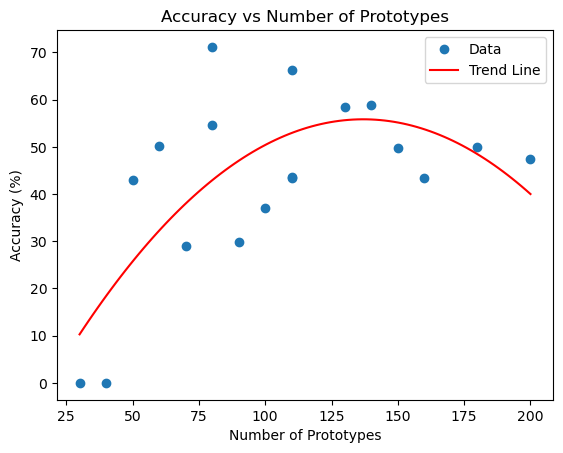

In [ ]:
coeffs = np.polyfit(*zip(*data), deg=2)
trend = np.poly1d(coeffs)
x_fit = np.linspace(min(data, key=lambda x: x[0])[0], max(data, key=lambda x: x[0])[0], 100)

plt.plot(*zip(*data), 'o', label='Data')
plt.plot(x_fit, trend(x_fit), 'r-', label='Trend Line')
plt.legend()
plt.xlabel('Number of Prototypes')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Prototypes')
plt.show()